# Goal
A Turkish R&D company was developing interior corner detection software. Previous approaches included principal component analysis in normalising point cloud data and reducing its dimensions, though ultimately unsuccessful.

The data was in the proprietary FBX (Filmbox) format, the orientation of the walls were not at a right angle to the "floor", and the rooms didn't have clear boundaries because of noise.

In [300]:
import matplotlib
# matplotlib.use('TkAgg') # If interactive
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.cluster import KMeans
from skimage.transform import probabilistic_hough_line
import cv2

import warnings
warnings.filterwarnings("ignore")


plt.style.use('~/.config/matplotlib/custom')

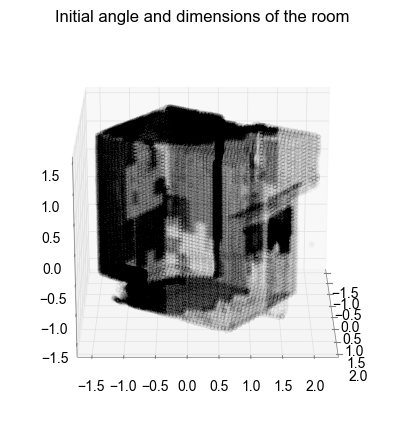

In [301]:
# xyz format is separated by spaces
df = pd.read_csv('./point-cloud/data/xyzs/kontrollu_oda.xyz', sep=' ')

# we don't need any columns beyond the first three
# as these are artefacts
df = df.drop(df.columns[3:], axis=1)
mat = df.to_numpy()

mu = np.mean(mat, axis=0)
mat = mat - mu

# swapping the y and z axes means the ceiling is oriented correctly
mat[:, [1, 2]] = mat[:, [2, 1]]
fig = plt.figure()
fig.set_figheight(5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mat[:,0], mat[:,1], mat[:,2], c='k', alpha=0.002, s=10)
ax.set_aspect('equal', adjustable='box')

# At a right angle, the walls are at an angle
ax.view_init(elev=20, azim=0)
plt.title("Initial angle and dimensions of the room")
plt.savefig("plots/init", bbox_inches="tight")
plt.show()

(1) Collapse only the highest 60% of datapoints to two dimensions to avoid noise of floor

(2) Split into pixels/ obtain a 2D histogram of where the points fall

In [302]:
# Sorting in terms of height of points, we take the top 60% to avoid noise
ceil = mat[mat[:, 2].argsort()][int(mat.shape[0]*0.6):,:]

# Only take x and y dimensions
ceil = ceil[:,:2]

# To implement line detection, we must split thedata into voxels. 
# The easiest way to do this is to plot a graph
fig, ax = plt.subplots(1)
ax.scatter(ceil[:,0], ceil[:, 1], color='k')
ax.set_aspect('equal', 'box')
ax.axis('off')

# Writes the changes
fig.canvas.draw()

# Supress popup
plt.ioff()

# Turn plot into a np matrix
img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

(3) Gaussian blurring with custom kernel to remove noise

(4) Canny edge detection to give line contour

In [303]:
# Blur any noise using a 9x9 kernel
blur = cv2.GaussianBlur(img, (15, 15), 0)

# Take only the sharpest edges
edge = cv2.Canny(blur, 200, 300)

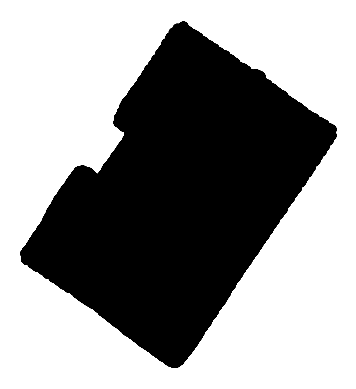

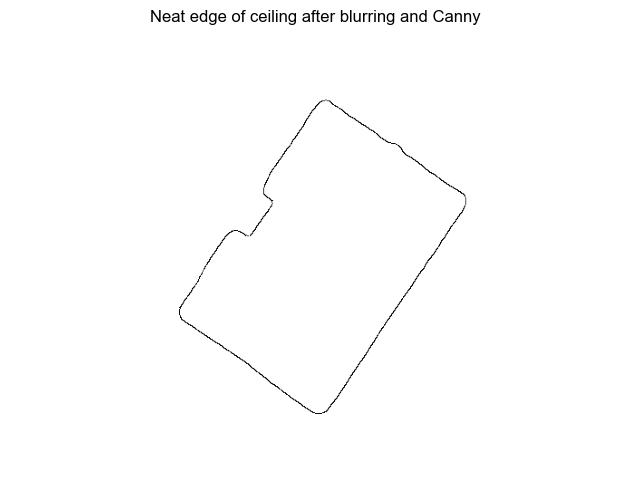

In [304]:
fig = plt.figure()
fig.set_figheight(5)
plt.imshow(edge, cmap='Greys')
plt.axis('equal')
plt.axis('off')
plt.title("Neat edge of ceiling after blurring and Canny")
plt.tight_layout()
plt.savefig('plots/edge', bbox_inches='tight')
plt.show()

(5) Fit lines using Hough Transform

(6) Turn point pairs denoting potential lines into normalised vectors

(Optional outlier detection for finetuning)

(7) (Assuming room has perpendicular walls) K-Means to split vectors to two groups based on orientation

In [305]:
# Using the Hough transform, we can detect the lines in this image.
# These lines are represented by two (x, y) pairs
lines = probabilistic_hough_line(edge, threshold=0, line_length=1, line_gap=10)

# Find the vector gradients of the lines 
# (e.g. y = [1 2] + y * [0 1] for a vertical line passing through [1 2])
grad = np.array([[(i[1][0]-i[0][0]),(i[1][1]-i[0][1])] for i in lines])

# Use l2 normalisation for each vector gradient
norms = np.linalg.norm(grad, axis=1)[:, np.newaxis]
norms = np.tile(norms, (1, 2))

# Divide both components of the vector elementwise
grad = grad / norms

# Potential outlier detection, assuming all walls are perpendicular to x, y axes
# outlier_idx = np.logical_and(grad[:,0] > 0.4, grad[:,1] > 0.4)

# First and second point that make up each line
arr0 = np.array(([[i[0][0],i[0][1]] for i in lines]))
arr1 = np.array([[i[1][0],i[1][1]] for i in lines])

# grad, arr1, arr2 = grad[~outlier_idx], arr1[~outlier_idx], arr2[~outlier_idx]

# Stack them into a (len(arr0) + len(arr1)) x 2 matrix
points = np.vstack((arr0, arr1))
p_mean = np.mean(points, axis=0)
points = points - p_mean

# Using K-Means we split the lines into two groups for perpendicular walls
km = KMeans(n_clusters=2).fit(grad)

# Returns a list of 0/1s corresponding to the group each gradient is assigned
labels = km.labels_

# Append to each (x, y) pair the labels. 
labelled_grad = np.hstack((grad, labels[:, np.newaxis]))

# The start and end points of the lines will have the same classification,
# so the labels are repeated
labelled_points = np.hstack((points, np.hstack((labels,labels))[:, np.newaxis]))
# For the two groups
d = [{},{}]

# The first and second new orthonormal basis vector (compared to [1 0] and [0 1])
b0 = np.median(labelled_grad[labelled_grad[:,2] == 0.][:,:2], axis=0)
b1 = np.array([1, -b0[0] / b0[1]])
b1 = b1 / np.linalg.norm(b1)
d[0]['b'], d[1]['b'] = b0, b1

# Classify the points into two groups
d[0]['points'], d[1]['points'] = (labelled_points[labelled_points[:,2] == i][:,:2] for i in range(2))

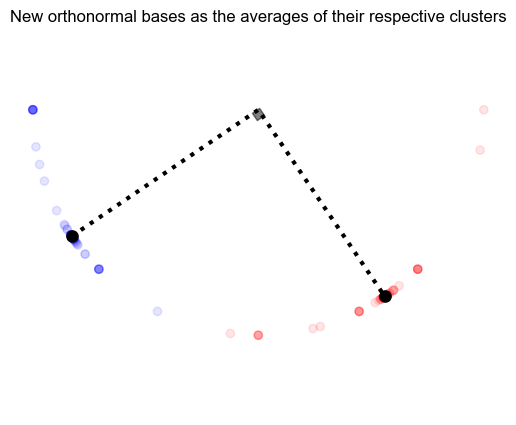

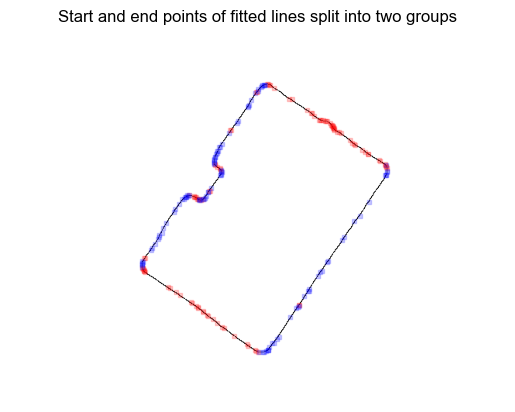

In [306]:
fig = plt.figure().set_figheight(5)
plt.scatter(grad[:,0], grad[:,1], c=labels, alpha=0.1, cmap="bwr")
plt.scatter(b0[0], b0[1], c='k', s=65)
plt.scatter(b1[0], b1[1], c='k', s=65)
plt.scatter(-0.001, -0.02, c='k', alpha=0.5, marker=(4, 0, 169), s=80)
plt.plot([b0[0], 0, b1[0]], [b0[1], 0, b1[1]], 'k:')
plt.axis('equal')
plt.axis('off')
plt.title("New orthonormal bases as the averages of their respective clusters")
plt.savefig('plots/orthonormal_basis', bbox_inches='tight')
plt.show()

fig = plt.figure().set_figheight(5)
cols = ['r', 'b']
for i in range(2):
    plt.scatter(d[i]['points'][:,0] + p_mean[0], d[i]['points'][:,1] + p_mean[1], marker='s', s=10, alpha=0.2, color=cols[i])
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.title("Start and end points of fitted lines split into two groups")
plt.savefig('plots/classified_points', bbox_inches='tight')
plt.show()

(8) Average vectors of each groups to generate orthonormal basis

(9) Rodrigues formula to rotate and normalise 3D point cloud

In [307]:
# Now that we know the bases/ eigenvectors, we can rotate the 3d point cloud
# axis of rotation = z axis
# normal of wall (without loss of generality) = [b0[0] b0[1] 0]

basis = np.array([1, 0, 0])

# Normal of fitted plane
norm = np.array([b0[0], b0[1], 0])
# Normalise the normal
norm = norm / np.linalg.norm(norm)

angle = -np.arccos(np.dot(norm, basis))



# Find axis of rotation perpendicular to norm and basis_x
axis = np.array([0, 0, 1])
# axis = axis / np.linalg.norm(axis)

# Use Rodrigues rotation formula to calculate rotation matrix
C = np.array([[0, -axis[2], axis[1]],
            [axis[2], 0, -axis[0]],
            [-axis[1], axis[0], 0]])
rot_mat =  np.identity(3) + np.sin(angle)*C + (1-np.cos(angle))*np.dot(C, C)
rot_mat_2d = np.array([[np.cos(angle), -np.sin(angle)],
                       [np.sin(angle), np.cos(angle)]])
# Rotate each point
new_mat = np.dot(rot_mat, mat.T).T
for i in range(2):

    # Cardinal bases in the form of [1 0], [0 1]
    d[i]['new_b'] = np.uint8(np.round(np.dot(d[i]['b'], rot_mat_2d)))

    # Along which axes do the points vary
    idx = np.argmin(d[i]['new_b'])

    # Transform points
    rotated = np.dot(d[i]['points'], rot_mat_2d)

    # Sort the rotated points
    d[i]['rotated'] = rotated[rotated[:, idx].argsort()]

    # Remove extra dimension
    d[i]['1d'] = d[i]['rotated'][:, idx]

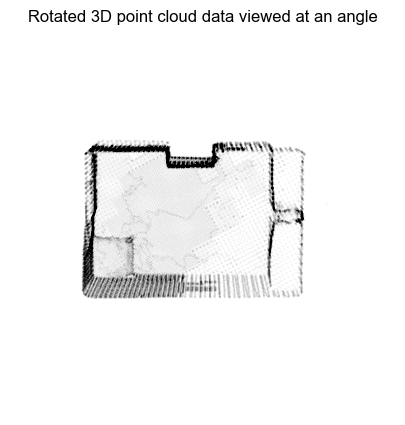

In [308]:
fig = plt.figure()
fig.set_figheight(5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_mat[:,0], new_mat[:,1], new_mat[:,2], c='k', alpha=0.002, s=1)
ax.set_aspect('equal', adjustable='box')

# At a right angle, the walls are no longer at an angle
ax.view_init(elev=95, azim=180)
plt.axis('off')
plt.title("Rotated 3D point cloud data viewed at an angle")
plt.savefig('plots/top', bbox_inches='tight')
plt.show()


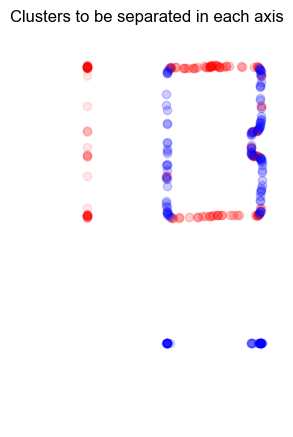

In [309]:
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(3)
# base = fig.add_axes(111)
for i in range(4):
    plt.gcf().get_axes()[i].axis('off')
for i in range(2):
    mult = np.tile(np.abs(d[i]['new_b'] - 1), (len(d[i]['rotated']), 1))
    s = d[i]['rotated'] * mult
    ax[0 + i, 0 + i].scatter(s[:,0], s[:,1], alpha=0.05, color=cols[i])
    ax[0, 1].scatter(d[i]['rotated'][:,0], d[i]['rotated'][:,1], alpha=0.2, color=cols[i])
# ax[0].axis('off')
# ax[1].axis('off')
fig.suptitle("Clusters to be separated in each axis")
plt.axis('equal')
plt.savefig('plots/one_dim', bbox_inches='tight')
plt.show()
    

(10) 1D adaptation of DBSCAN to cluster vectors into their respective walls

In [310]:
eps = 2
n_thresh = 3
# For each sideRotated 3D point cloud data viewed at an angle
for n in range(2):

    # Points of current side
    curr_points = d[n]['1d']
    curr_label = 0
    labels = np.zeros_like(curr_points)

    for i, j in enumerate(curr_points[:-1]):

        # If the next point is closer than eps units, it receives the same label
        if j + eps >= curr_points[i+1]:
            labels[i+1] = curr_label
        else:
            curr_label += 1
            labels[i+1] = curr_label
    n_labels = 0

    # Separate into clusters by label
    for i in range(curr_label+1):
        cluster = d[n]['rotated'][labels == float(i),:]
        
        # Only clusters with n_points greater than threshold remain to filter out noise
        if cluster.shape[0] > n_thresh:
            d[n][f'{n_labels}'] = cluster
            s = np.mean(cluster, axis=0)
            d[n][f's{n_labels}'] = s
            n_labels += 1
    d[n]['n'] = n_labels
print([d[i].keys() for i in range(2)])

[dict_keys(['b', 'points', 'new_b', 'rotated', '1d', '0', 's0', '1', 's1', '2', 's2', '3', 's3', 'n']), dict_keys(['b', 'points', 'new_b', 'rotated', '1d', '0', 's0', '1', 's1', '2', 's2', 'n'])]


(11) Solve for all intersections of average vectors (direction) of each wall group

In [311]:
# For appending to
corners = np.zeros((1, 2))

# Linearly solve to find all possible intersections
a = np.vstack((d[0]['new_b'], -d[1]['new_b']))
for i in range(d[0]['n']):
    for j in range(d[1]['n']):

        # a * lam = b
        b = d[0][f's{i}'] - d[1][f's{j}']

        # vector of parameters
        lam = np.linalg.solve(a, b[:, np.newaxis])

        # Reconstruct Cartesian point
        x0 = d[0][f's{i}'] - lam[0] * d[0]['new_b']

        # Append to previous corners
        corners = np.vstack((corners, x0[np.newaxis, :]))
corners = corners[1:,:]
norm_corn = (corners - np.min(corners))
norm_corn # Image dimensions

array([[ 27.89426166,   0.        ],
       [206.48993201,   0.        ],
       [225.24663025,   0.        ],
       [ 27.89426166, 116.97897606],
       [206.48993201, 116.97897606],
       [225.24663025, 116.97897606],
       [ 27.89426166, 165.06651147],
       [206.48993201, 165.06651147],
       [225.24663025, 165.06651147],
       [ 27.89426166, 290.44916544],
       [206.48993201, 290.44916544],
       [225.24663025, 290.44916544]])

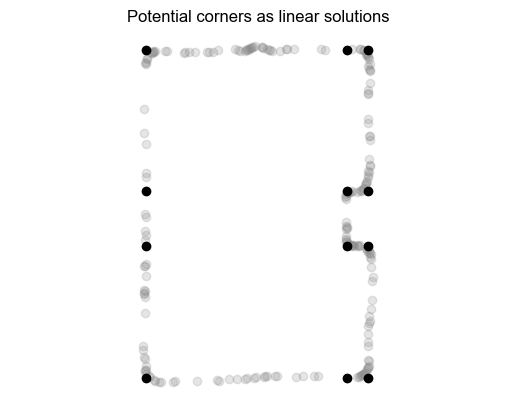

In [312]:

# fig = plt.figure().set_figheight(3)
for i in range(2):
    plt.scatter(d[i]['rotated'][:,0], d[i]['rotated'][:,1], alpha=0.2, c='0.5')
    for j in range(d[i]['n']):
        f = d[i][f's{j}']
plt.scatter(corners[:,0], corners[:,1], c='k')
plt.axis('equal')
plt.axis('off')
plt.title("Potential corners as linear solutions")
plt.savefig('plots/with_corners', bbox_inches='tight')
plt.show()

(12) Collapse 3D data horizontally to find histogram peaks indicating wall positions

(13) Calculate actual room dimensions

In [313]:
n_bins = 100
dims = np.zeros(2)

x, y = new_mat[:, 1], new_mat[:, 0]

for i, j in enumerate([y, x]):

    # Interval in which bins are located
    interval = np.min(j), np.max(j)
    bins = np.linspace(*interval, n_bins)

    # Take midpoint of each bin
    midpoints = (bins[1:] + bins[:-1]) / 2

    # Find which midpoints are greater than 0
    pos = midpoints > 0

    # Count per bin
    counts, _ = np.histogram(j, bins, density=True)

    # For each side of the number line
    ub, lb = midpoints[pos][np.argmax(counts[pos])], midpoints[~pos][np.argmax(counts[~pos])]
    dims[i] = ub - lb
dims

array([1.94515017, 2.62721777])

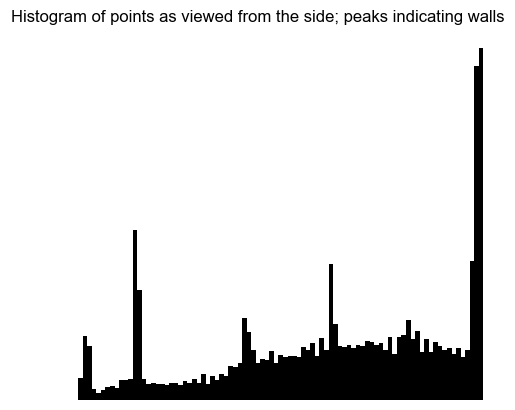

In [314]:
plt.bar(np.arange(len(counts)), counts, color='k', width=1)
plt.axis('off')
plt.title("Histogram of points as viewed from the side; peaks indicating walls")
plt.show()

(14) Using room dimensions, move the corner positions from image space to real life units

In [315]:
factor = np.mean(np.ptp(norm_corn, axis=0) / dims)
corns = np.round(norm_corn / factor, 2)
corns[:, 0] -= corns[:, 0].min()
corns[:, 1] -= corns[:, 1].min()
corns

array([[0.  , 0.  ],
       [1.69, 0.  ],
       [1.86, 0.  ],
       [0.  , 1.1 ],
       [1.69, 1.1 ],
       [1.86, 1.1 ],
       [0.  , 1.56],
       [1.69, 1.56],
       [1.86, 1.56],
       [0.  , 2.74],
       [1.69, 2.74],
       [1.86, 2.74]])

(15) Find minimum distance connector of all points

In [328]:
# Initialize an empty list 'g' to store tuples.
g = []

c = defaultdict()
d = defaultdict()
max_num = 0
edges = []
mean = np.mean(corns, axis=0)
for idx, (i, j) in enumerate(corns):
    c[idx] = np.array([i, j])
    d[str(i) + "," + str(j)] = idx

for i1, j1 in corns:
    for i2, j2 in corns:
        id1 = d[str(i1) + "," + str(j1)]
        id2 = d[str(i2) + "," + str(j2)]
        if id1 == id2:
            continue
        
        # Skip if the pairs cannot be connected by one of the perpendicular bases (ie are connected diagonally)
        if np.min(np.abs(c[id1]- c[id2])) != 0:
            continue
        
        # Calculate distance between the coordinates and append the result to 'g'.
        g.append((id1, id2, int(1000 * np.linalg.norm(np.abs(c[id1] - c[id2]))), np.abs(c[id1]- c[id2])[0] > 0))

g = np.array(g)
g[:10]

array([[   0,    1, 1690,    1],
       [   0,    2, 1860,    1],
       [   0,    3, 1100,    0],
       [   0,    6, 1560,    0],
       [   0,    9, 2740,    0],
       [   1,    0, 1690,    1],
       [   1,    2,  170,    1],
       [   1,    4, 1100,    0],
       [   1,    7, 1560,    0],
       [   1,   10, 2740,    0]])

In [325]:

pivots = []
pairs = []
n_nodes = len(np.unique(g[:, 0]))

# 2 if the node has two connections left. When a node is connected on either side it is 0
status = np.zeros(n_nodes) + 2
node = next_node = 0

# Arbitrary value not equal to 0 or 1
prev_dir = 100
visited = []

def calc_next(n, g, v):
    # Filter 'g' for links from node 'n'.
    portion = g[g[:, 0] == n]

    # Sort the filtered portion based on the third column (distance).
    sort = np.argsort(portion[:, 2])

    # Create an offset array to mark unvisited nodes.
    mask = [(portion[:, 1][sort[i]] not in v) for i in range(5)]

    # Get the unvisited node that is the shortest distance away
    n_n = portion[:, 1][sort[mask][0]]

    # Get the direction associated with the next node.
    dir = portion[portion[:, 1] == n_n][:, 3]
    return n_n, dir

next_status = 2
try:
    while next_status:
        next_node, dir = calc_next(node, g, visited)

        # If the direction changes, mark the current node as a pivot.
        if dir != prev_dir:
            pivots.append((node))
            
        next_status = status[next_node]
        status[[node, next_node]] -= 1
        pairs.append((node, next_node))
        visited.append(node)
        node = next_node
        prev_dir = dir
# If an IndexError occurs, it means all nodes have been visited.
except IndexError:
    # Complete the loop
    pairs.append((status > 0).argsort()[-2:].tolist())


# Select coordinates of the essential corners from 'corns' based on 'pivots'.
ceil_corns = corns[np.array(pivots)]
ceil_corns

array([[0.  , 0.  ],
       [0.  , 2.74],
       [1.86, 2.74],
       [1.86, 1.56],
       [1.69, 1.56],
       [1.69, 1.1 ],
       [1.86, 1.1 ],
       [1.86, 0.  ]])

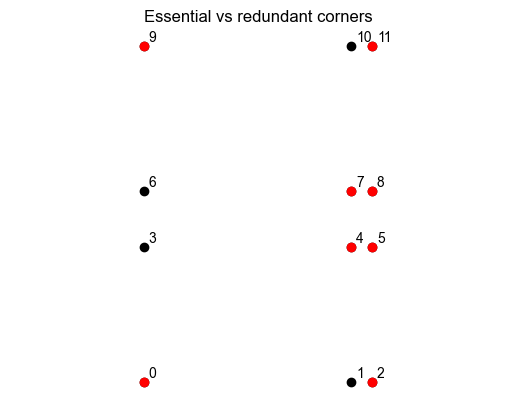

In [326]:
plt.scatter(corns[:, 0], corns[:, 1], c='k')
for idx, j in enumerate(corns):
    plt.annotate(str(idx), c[idx] + 0.04)
plt.scatter(ceil_corns[:,0], ceil_corns[:,1], c='r')
plt.title("Essential vs redundant corners")
plt.savefig("plots/essential", bbox_inches="tight")
plt.axis('equal')
plt.axis('off')
plt.show()

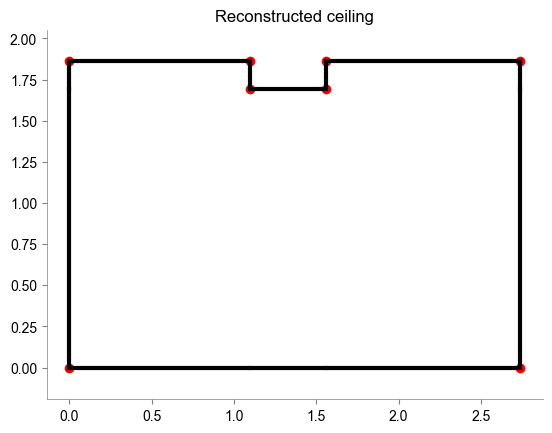

In [327]:
for i, j in pairs:
    xs = [c[j][1], c[i][1]]
    ys = [c[j][0], c[i][0]]
    plt.plot(xs, ys, 'k')
plt.scatter(ceil_corns[:, 1], ceil_corns[:, 0], c='r')
plt.title("Reconstructed ceiling")
plt.savefig("plots/reconstructed", bbox_inches="tight")
plt.axis('equal')
plt.show()

# Next steps:
- This algorithm only works for walls with indents at right angles
- Further image processing (e.g. slight warping of walls to decrease straightness) might improve Hough transform predictions
- Wider testing on other rooms with varying qualities of point cloud data